In [1]:
import os
import json
from typing import Dict, List
import requests
import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup
import unicodedata
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from pprint import pprint
from requests import get

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from env import github_token
from env import github_username

import acquire_titanic

import prep

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer



Explore dataframes that are repositories that are in a github search of Titanic, and have the most starts. We pulled the top 180 repos

In [2]:
# Look at the data frame we have brought in.
df = acquire_titanic.scrape_github_data()
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
language           170 non-null object
readme_contents    180 non-null object
repo               180 non-null object
dtypes: object(3)
memory usage: 4.3+ KB


In [3]:
len(df)

180

Some of our repos do not have readme's

In [4]:
no_readme_df = df[df.readme_contents == 'error: no README']
no_readme_df

,language,readme_contents,repo
6,Jupyter Notebook,error: no README,minsuk-heo/kaggle-titanic
8,Jupyter Notebook,error: no README,shantnu/Titanic-Machine-Learning
26,Python,error: no README,mazurkin/titanic
74,Python,error: no README,codebugged/Titanic
88,Java,error: no README,joedayz/titanic-javaee7
90,R,error: no README,GeekyTheory/Taller-Big-Data-R-Titanic-IEEE
105,Python,error: no README,Mineria/Titanic
107,Jupyter Notebook,error: no README,MSusik/titanic
117,JavaScript,error: no README,ravinderpayal/Titanicturer
121,Jupyter Notebook,error: no README,mayank408/Data-Science-Hands-On


In [5]:
len(no_readme_df)

15

In [6]:
# make a copy of orginal df. This keeps the original df intact
#df_prep = df.copy()

In [7]:
df = df[df.readme_contents != 'error: no README']

In [8]:
len(df)

165

In [9]:
df = prep.prep_articles(df)

In [10]:
df.clean[112]

'titanicexample'

In [11]:
df.head()

,language,repo,original,stemmed,lemmatized,clean
0,JavaScript,icons8/titanic,# Titanic\n\nA collection of animated icons + ...,titan a collect of anim icon javascript librar...,titanic a collection of animated icon javascri...,collection animated icons javascript library p...
1,Java,romainpiel/Titanic,# Titanic for Android\n\nThis library is DEPRE...,titan for android thi librari is deprec as i d...,titanic for android this library is deprecated...,android library deprecated time mainatin anymo...
2,Jupyter Notebook,agconti/kaggle-titanic,### Kaggle-titanic\nThis is a tutorial in an I...,kaggletitan thi is a tutori in an ipython note...,kaggletitanic this is a tutorial in an ipython...,kaggletitanic tutorial kaggle competition disa...
3,Jupyter Notebook,HanXiaoyang/Kaggle_Titanic,# Kaggle_Titanic\nthe data and ipython noteboo...,kaggletitan the data and ipython notebook of m...,kaggletitanic the data and ipython notebook of...,kaggletitanic attempt solve kaggle problem kag...
4,R,trevorstephens/titanic,Titanic: Machine Learning from Disaster - Gett...,titan machin learn from disast get start with ...,titanic machine learning from disaster getting...,disaster getting started r trevor stephens jan...


In [12]:
df.language.value_counts(dropna=False)

Jupyter Notebook    74
Python              35
R                   15
NaN                 10
HTML                 9
JavaScript           6
Scala                4
Java                 3
F#                   2
Processing           1
PHP                  1
Rust                 1
C                    1
C++                  1
Clojure              1
OpenEdge ABL         1
Name: language, dtype: int64

In [13]:
labels = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
Jupyter Notebook,74,0.477419
Python,35,0.225806
R,15,0.096774
HTML,9,0.058065
JavaScript,6,0.038710
Scala,4,0.025806
Java,3,0.019355
F#,2,0.012903
Processing,1,0.006452
PHP,1,0.006452


In [14]:
top_langs = list(labels[labels.n > 6].index)
top_langs

['Jupyter Notebook', 'Python', 'R', 'HTML']

In [15]:
low_langs = list(labels[labels.n <= 6].index)
low_langs

['JavaScript',
 'Scala',
 'Java',
 'F#',
 'Processing',
 'PHP',
 'Rust',
 'C',
 'C++',
 'Clojure',
 'OpenEdge ABL']

In [16]:
top_counts = list(labels[labels.n > 6].n)
top_counts

[74, 35, 15, 9]

In [17]:
low_count_total = sum(list(labels[labels.n  <=6].n))
low_count_total

22

In [18]:
langs_counts = []
for x in range(len(top_counts)):
    langs_counts.append(f'{top_counts[x]} : {top_langs[x]}')
langs_counts

['74 : Jupyter Notebook', '35 : Python', '15 : R', '9 : HTML']

In [19]:
langs_counts.append(f'{low_count_total} : Various Other Languages')
langs_counts

['74 : Jupyter Notebook',
 '35 : Python',
 '15 : R',
 '9 : HTML',
 '22 : Various Other Languages']

In [20]:
counts = []
for n in range(len(langs_counts)):
    counts.append(int(langs_counts[n].split()[0]))
counts

[74, 35, 15, 9, 22]

In [21]:
import explore_charts

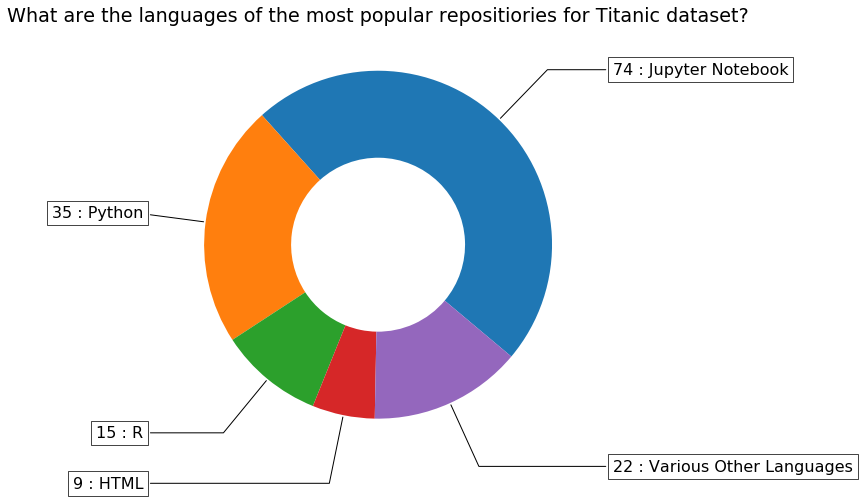

In [22]:
plt.rc('font', size = 16 )
explore_charts.donut_chart(langs_counts, counts)

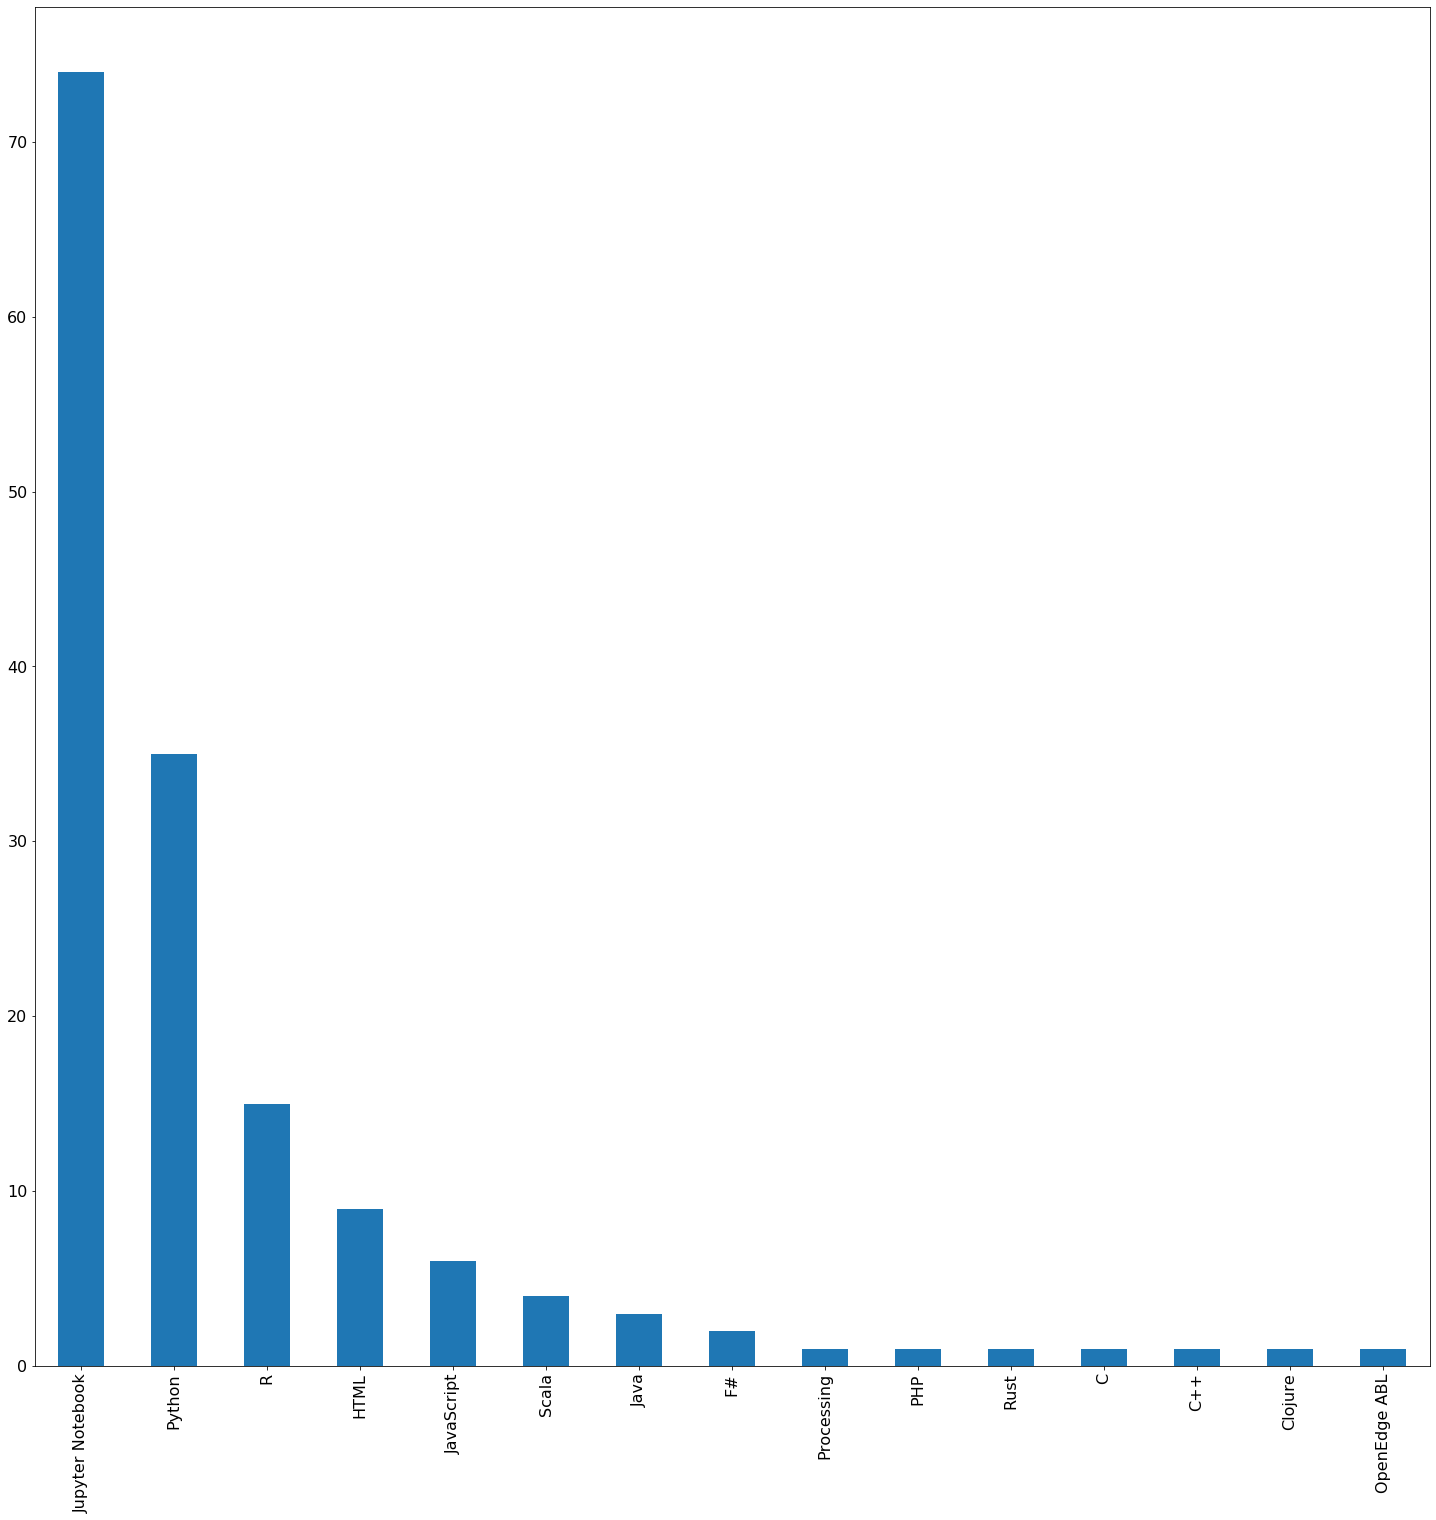

In [23]:
# explore the distribution of languages.
plt.rc('font', size=16)
plt.figure(figsize = (25,25))
labels.n.plot.bar()

In [24]:
df.columns

Index(['language', 'repo', 'original', 'stemmed', 'lemmatized', 'clean'], dtype='object')

looking

In [ ]:
easy_df = df.drop(columns =(['repo', 'original', 'stemmed', 'lemmatized']))
easy_df

In [ ]:
breakouts = pd.concat([easy_df.language.value_counts(),
                    easy_df.language.value_counts(normalize=True)], axis=1)
breakouts.columns = ['n', 'percent']
breakouts

In [ ]:
all_text = " ".join(easy_df.clean)
all_text = all_text.split()
all_text_counts = pd.Series(all_text).value_counts()

javascript_text = " ".join(easy_df[easy_df.language == "JavaScript"].clean)
javascript_text = javascript_text.split()
javascript_text_counts = pd.Series(javascript_text).value_counts()

jupyter_text = " ".join(easy_df[easy_df.language == "Jupyter Notebook"].clean)
jupyter_text = jupyter_text.split()
jupyter_text_counts = pd.Series(jupyter_text).value_counts()

python_text = " ".join(easy_df[easy_df.language == "Python"].clean)
python_text = python_text.split()
python_text_counts = pd.Series(python_text).value_counts()

java_text = " ".join(easy_df[easy_df.language == "Java"].clean)
java_text = java_text.split()
java_text_counts = pd.Series(java_text).value_counts()

cplus_text = " ".join(easy_df[easy_df.language == "C++"].clean)
cplus_text = cplus_text.split()
cplus_text_counts = pd.Series(cplus_text).value_counts()

go_text = " ".join(easy_df[easy_df.language == "Go"].clean)
go_text = go_text.split()
go_text_counts = pd.Series(go_text).value_counts()


In [ ]:
word_counts = (pd.concat([all_text_counts, javascript_text_counts, jupyter_text_counts, python_text_counts, java_text_counts, cplus_text_counts, go_text_counts], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'jupyter', 'python', 'java', 'cplus', 'go'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
word_counts

In [ ]:
word_counts.sort_values(by='all', ascending=False
                       ).head(10)

In [ ]:
pd.concat([word_counts[word_counts.javascript == 0].sort_values(by='javascript').tail(6),
           word_counts[word_counts.jupyter == 0].sort_values(by='jupyter').tail(6),
          word_counts[word_counts.python == 0].sort_values(by='python').tail(6),
           word_counts[word_counts.java == 0].sort_values(by='java').tail(6),
           word_counts[word_counts.cplus == 0].sort_values(by='cplus').tail(6),
           word_counts[word_counts.go == 0].sort_values(by='go').tail(6)])

In [ ]:
top_20_text_bigrams = (pd.Series(nltk.ngrams(all_text, 2))
                      .value_counts()
                      .head(20))

top_20_javascript = (pd.Series(nltk.ngrams(python_text, 2))
                      .value_counts()
                      .head(20))

top_20_jupyter_bigrams = (pd.Series(nltk.ngrams(jupyter_text, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams = (pd.Series(nltk.ngrams(python_text, 2))
                      .value_counts()
                      .head(20))

top_20_java_bigrams = (pd.Series(nltk.ngrams(java_text, 2))
                      .value_counts()
                      .head(20))



top_20_cplus_bigrams = (pd.Series(nltk.ngrams(cplus_text, 2))
                      .value_counts()
                      .head(20))

top_20_go_bigrams = (pd.Series(nltk.ngrams(go_text, 2))
                      .value_counts()
                      .head(20))

# Modeling

In [ ]:
tfidf = TfidfVectorizer()
tfidf

In [ ]:
# drop where language == None
easy_df = easy_df[easy_df.language.isna() == False]

In [ ]:
value_counts_df = pd.DataFrame(easy_df.language.value_counts(dropna = False))
value_counts_df

In [ ]:
one_doc_langs = list(value_counts_df[value_counts_df.language < 2].index)
one_doc_langs

In [ ]:
for x in one_doc_langs:
    easy_df = easy_df[easy_df.language != x]

In [ ]:
easy_df.language.value_counts()

In [ ]:
X = tfidf.fit_transform(easy_df.clean)
X

In [ ]:
y= easy_df.language
y.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = .3)

In [ ]:
train = pd.DataFrame(dict(acutal = y_train))
train.head()

In [ ]:
test = pd.DataFrame(dict(actual=y_test))
test.head()

In [ ]:
lm = LogisticRegression().fit(X_train, y_train)
lm

In [ ]:
train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [ ]:
train

In [ ]:
accuracy_score(train.acutal, train.predicted)

In [ ]:
80/163

In [ ]:
accuracy_score(test.actual, test.predicted)

In [ ]:
print(classification_report(train.acutal, train.predicted))

In [ ]:
pd.crosstab(train.predicted, train.acutal)

In [ ]:
easy_df = easy_df[easy_df.clean != 'error readme']
easy_df.head()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .30, random_state = 123)
#X_train.head()

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=123)


In [ ]:
clf.fit(X_train, y_train)


In [ ]:
clf.score(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=5, 
                            random_state=123)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_train)

In [ ]:
rf.score(X_train,y_train)

In [ ]:
rf.score(X_test, y_test)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly = PolynomialFeatures(2)
poly

In [ ]:
poly.fit(X_train, y_train)

In [ ]:
poly.fit_transform(X_train)

In [ ]:
lm = LogisticRegression().fit(X_train, y_train)
